# Generative Adversarial Networks
---
Based on implementation from [here](https://github.com/eriklindernoren/PyTorch-GAN/blob/master/implementations/gan/gan.py).

In [1]:
import sys
sys.path.append('../')
from src import logging as lg

In [2]:
import numpy as np
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
from torch.autograd import Variable

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)

In [3]:
BATCH_SIZE = 256
EPOCHS = 25
LOG_INTERVAL = 100
CUDA = False #torch.cuda.is_available()

torch.manual_seed(1)

device = torch.device("cuda" if CUDA else "cpu")

kwargs = {'num_workers': 1, 'pin_memory': True} if CUDA else {}
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.ToTensor()),
    batch_size=BATCH_SIZE, shuffle=True, **kwargs)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.ToTensor()),
    batch_size=BATCH_SIZE, shuffle=True, **kwargs)

In [4]:
dataloader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                   ])),
    batch_size=BATCH_SIZE, shuffle=True)

# Discriminator

In [5]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.fc1 = nn.Linear(784, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 1)

    def forward(self, x):
        x = F.leaky_relu(self.fc1(x))
        x = F.leaky_relu(self.fc2(x))
        x = F.sigmoid(self.fc3(x))
        
        return x

# Generator

In [6]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.fc1 = nn.Linear(10, 128)
        self.bn1 = nn.BatchNorm1d(128)
        self.fc2 = nn.Linear(128, 256)
        self.bn2 = nn.BatchNorm1d(256)
        self.fc3 = nn.Linear(256, 512)
        self.bn3 = nn.BatchNorm1d(512)
        self.fc4 = nn.Linear(512, 1024)
        self.bn4 = nn.BatchNorm1d(1024)
        self.fc5 = nn.Linear(1024, 784)

    def forward(self, x):
        x = self.bn1(self.fc1(x))
        x = self.bn2(self.fc2(x))
        x = self.bn3(self.fc3(x))
        x = self.bn4(self.fc4(x))
        x = F.tanh(self.fc5(x))
        
        return x

In [7]:
D = Discriminator()
G = Generator()

# Loss function
adversarial_loss = torch.nn.BCELoss()

optimizer_G = torch.optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = torch.optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))

### Gradient ascent on Discriminator ###
$min_{\theta_{g}} max_{\theta_{d}}\mathop{{}\mathbb{E}}_{x \sim p_{data}} [log D_{\theta}(x) + \mathop{{}\mathbb{E}}_{z \sim p(z)} log(1 - D_{\theta_{d}}(G_{\theta_{g}}(z)))]$

### Gradient ascent on Generator ###
$min_{\theta_{g}} \mathop{{}\mathbb{E}}_{z \sim p(z)} log D_{\theta_{d}}(G_{\theta_{g}}(z))$

In [8]:
Tensor = torch.cuda.FloatTensor if CUDA else torch.FloatTensor
loss = {'G':[], 'D':[]}
for epoch in range(EPOCHS):
    for i, (imgs, _) in enumerate(dataloader):
        # Adversarial ground truths
        valid = Variable(Tensor(imgs.size(0), 1).fill_(1.0), requires_grad=False)
        fake = Variable(Tensor(imgs.size(0), 1).fill_(0.0), requires_grad=False)

        # Configure input
        real_imgs = Variable(imgs.type(Tensor)).view(-1,784)

        # -----------------
        #  Train Generator
        # -----------------
        optimizer_G.zero_grad()

        # Sample noise as generator input
        z = Variable(Tensor(np.random.normal(0, 1, (imgs.shape[0], 10))))

        # Generate a batch of images
        gen_imgs = G(z).reshape(-1,784)

        # Loss measures generator's ability to fool the discriminator
        g_loss = adversarial_loss(D(gen_imgs), valid)

        g_loss.backward()
        optimizer_G.step()

        # ---------------------
        #  Train Discriminator
        # ---------------------
        optimizer_D.zero_grad()
        
        # Measure discriminator's ability to classify real from generated samples
        real_loss = adversarial_loss(D(real_imgs), valid)
        fake_loss = adversarial_loss(D(gen_imgs.detach()), fake)
        d_loss = (real_loss + fake_loss) / 2

        d_loss.backward()
        optimizer_D.step()

        #print ("[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]" % (epoch, EPOCHS, i, len(dataloader),d_loss.item(), g_loss.item()))
        lg.update("[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]" % (epoch, EPOCHS, i, len(dataloader),d_loss.item(), g_loss.item()))
        loss['D'].append(d_loss.item())
        loss['G'].append(g_loss.item())
        
    # save gen img
    gen_imgs = gen_imgs.reshape(-1,1,28,28)
    save_image(gen_imgs.data[:25], 'Results/GAN Results/%d.png' % epoch, nrow=5, normalize=True)
    
    lg.new_line()

[Epoch 0/25] [Batch 234/235] [D loss: 0.450485] [G loss: 1.190670]
[Epoch 1/25] [Batch 234/235] [D loss: 0.603064] [G loss: 0.731678]
[Epoch 2/25] [Batch 234/235] [D loss: 0.617150] [G loss: 1.094991]
[Epoch 3/25] [Batch 234/235] [D loss: 0.567623] [G loss: 1.064286]
[Epoch 4/25] [Batch 234/235] [D loss: 0.537822] [G loss: 1.160008]
[Epoch 5/25] [Batch 234/235] [D loss: 0.473000] [G loss: 0.818348]
[Epoch 6/25] [Batch 234/235] [D loss: 0.334430] [G loss: 1.509413]
[Epoch 7/25] [Batch 234/235] [D loss: 0.289078] [G loss: 2.143028]
[Epoch 8/25] [Batch 234/235] [D loss: 0.245271] [G loss: 1.941004]
[Epoch 9/25] [Batch 234/235] [D loss: 0.238245] [G loss: 1.707411]
[Epoch 10/25] [Batch 234/235] [D loss: 0.253693] [G loss: 1.963282]
[Epoch 11/25] [Batch 234/235] [D loss: 0.186107] [G loss: 2.228275]
[Epoch 12/25] [Batch 234/235] [D loss: 0.165765] [G loss: 2.978479]
[Epoch 13/25] [Batch 234/235] [D loss: 0.207192] [G loss: 3.034019]
[Epoch 14/25] [Batch 234/235] [D loss: 0.117623] [G loss: 

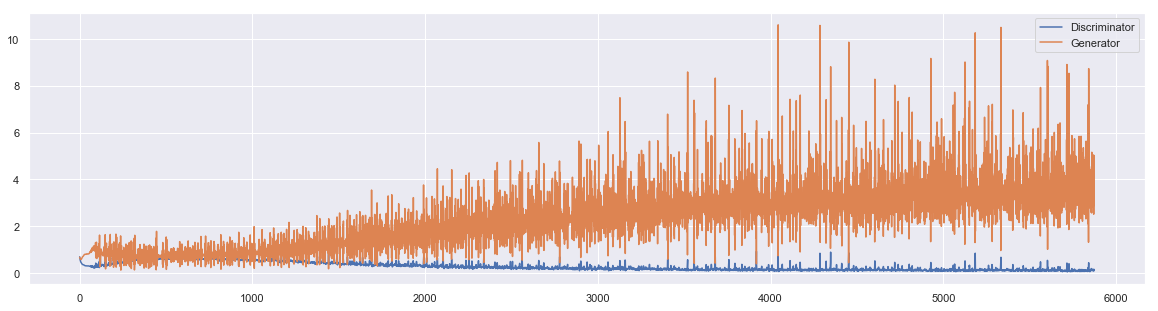

In [9]:
plt.figure(2,figsize=(20,5))
plt.plot(loss['D'],label='Discriminator')
plt.plot(loss['G'],label='Generator')
plt.legend()
plt.show()